# Statistical Analysis of Data

## Environment Settings

An statistical Analysis of the data captured will be performed.

The environment configuration is the following:

- A rectangle area is used whose dimension is 3 x 3 meters simetric environment. 
- A custom robot similar to an epuck was used.
- The robot starts in the middle of the arena.
- The robot moves in a random fashion way around the environment avoiding obstacles for 100 robot steps then it is moved into another random location.
- The data is not normalized in this experiment.
- The robot has 8 sensors that measure the distance between the robot and the walls.
- Some noise was introduced in the sensors measurements of the robot using the concept of [lookup tables](https://cyberbotics.com/doc/reference/distancesensor) in the Webots simulator which according to Webots documentation "The first column of the table specifies the input distances, the second column specifies the corresponding desired response values, and the third column indicates the desired standard deviation of the noise. The noise on the return value is computed according to a gaussian random number distribution whose range is calculated as a percent of the response value (two times the standard deviation is often referred to as the signal quality)". The following values were taken:

        - (0, 0, 0.05)
        - (10, 10, 0.05)
        
- The simulator runs during 25 hours of simulation (~20 minutes in fast mode).

In [1]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install scikit-learn
!{sys.executable} -m pip install keras

import pandas as pd
import tensorflow as tf
import numpy as np
import math
from sklearn.ensemble import RandomForestRegressor
from keras import models
from keras import layers
from keras import regularizers
import matplotlib.pyplot as plt
from keras import optimizers

Using TensorFlow backend.


# First Experiment

In [2]:
csv_file = 'robot_info_dataset.csv'
df = pd.read_csv(csv_file)
df[['x', 'y', 'theta', 'sensor_1', 'sensor_2','sensor_3','sensor_4','sensor_5','sensor_6','sensor_7', 'sensor_8']].head()

,x,y,theta,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8
0,2.661344,0.209868,122.455509,0.850504,0.567515,0.281329,0.327506,0.151153,0.206528,1.205781,1.428151
1,2.661345,0.209866,122.455707,0.906365,0.559246,0.317335,0.337301,0.160830,0.217641,1.179596,1.367341
2,2.660057,0.211891,122.456647,0.925396,0.543504,0.277720,0.323325,0.169616,0.218241,1.106886,1.324042
3,2.658769,0.213916,122.457724,0.826706,0.549208,0.289045,0.329547,0.162631,0.200034,1.144848,1.442325
4,2.657481,0.215941,122.458839,0.953127,0.566460,0.284548,0.328043,0.169804,0.204854,1.259341,1.319123


## Data pre-processing

The data collected 3384020 samples.

In [8]:
df.shape


(1125965, 15)

The data set contains some null values so they should be deleted from the samples.

In [7]:
df = df.dropna()
df = df.sample(frac=1)
df = df[:1125965]

## Input and output variables

The data will be split into training, testing and validation sets. 60% of the data will be used for training, 20% for training and 20% of validation.

In [9]:

# train size
test_size_percentage = .2
train_size_percentage = .8
ds_size = df.shape[0]
train_size = int(train_size_percentage * ds_size)
test_size = int(test_size_percentage * ds_size)

# shuffle dataset
sampled_df = df.sample(frac=1)

# separate inputs from outputs
inputs = sampled_df[['x', 'y', 'theta']]
targets = sampled_df[['sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5', 'sensor_6', 'sensor_7', 'sensor_8']]

# train
train_inputs = inputs[:train_size]
train_targets = targets[:train_size]

# test
test_inputs = inputs[train_size:]
test_targets = targets[train_size:]

inputs.head()

,x,y,theta
2518234,0.678506,0.950660,100.316169
1274068,0.639771,0.392730,284.636198
265676,1.899279,1.112279,301.861607
3342117,1.596643,1.976914,329.744236
256548,1.124840,0.901020,313.907034


## Neural Network


As input the neural network receives the x, y coordinates and rotation angle $\theta$. The output are the sensor measurements. One model per sensor will be created.

In [10]:

def get_model():
    # neural network with a 10-neuron hidden layer
    model = models.Sequential()
    model.add(layers.Dense(16, activation='relu', input_shape=(3,)))
#     model.add(layers.Dropout(0.5))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(1))
    
#     rmsprop = optimizers.RMSprop(learning_rate=0.01)
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
              
    return model

In [11]:
def k_fold(sensor_number, num_epochs=10, k=5):
    num_val_samples = len(train_inputs) // k
    validation_scores = []
    histories = []
    nmse = []

    for i in range(k):
        print('processing fold #', i)
        val_data = train_inputs[i * num_val_samples: (i + 1) * num_val_samples]
        val_targets = train_targets[[sensor_number]][i * num_val_samples: (i + 1) * num_val_samples]

        partial_train_data = np.concatenate(
            [train_inputs[:i * num_val_samples],
             train_inputs[(i + 1) * num_val_samples:]], axis=0)
        partial_train_targets = np.concatenate(
            [train_targets[[sensor_number]][:i * num_val_samples],
             train_targets[[sensor_number]][(i + 1) * num_val_samples:]], axis=0)


        model = get_model()

        history = model.fit(partial_train_data, partial_train_targets,
                            validation_data=(val_data, val_targets),
                            epochs=num_epochs, batch_size=64, verbose=1)
        histories.append(history.history)

        predictions_targets = model.predict(val_data)
        nmse.append(np.mean((predictions_targets - val_targets)**2)/np.var(val_targets))
        
    return histories, nmse


In [12]:
histories, nmse = k_fold('sensor_3', 50, 3)

processing fold # 0
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 600515 samples, validate on 300257 samples
Epoch 1/50
600515/600515 [==============================] - 14s 23us/step - loss: 0.3065 - mae: 0.3577 - val_loss: 0.1766 - val_mae: 0.3091
Epoch 2/50
600515/600515 [==============================] - 13s 22us/step - loss: 0.1135 - mae: 0.2494 - val_loss: 0.1427 - val_mae: 0.2721
Epoch 3/50
600515/600515 [==============================] - 13s 22us/step - loss: 0.0954 - mae: 0.2221 - val_loss: 0.1212 - val_mae: 0.2570
Epoch 4/50
600515/600515 [==============================] - 13s 22us/step - loss: 0.0838 - mae: 0.2042 - val_loss: 0.1083 - val_mae: 0.2296
Epoch 5/50
600515/600515 [==============================] - 13s 22us/step - loss: 0.0754 - mae: 0.1919 - val_loss: 0.1595 - val_mae: 0.2885
Epoch 6/50
600515/600515 [==============================] - 14s 23us/step - loss: 0.0689 - mae: 0.1811 - val

600515/600515 [==============================] - 12s 20us/step - loss: 0.0814 - mae: 0.2018 - val_loss: 0.0756 - val_mae: 0.2014
Epoch 5/50
600515/600515 [==============================] - 12s 20us/step - loss: 0.0725 - mae: 0.1877 - val_loss: 0.0696 - val_mae: 0.1853
Epoch 6/50
600515/600515 [==============================] - 12s 20us/step - loss: 0.0669 - mae: 0.1781 - val_loss: 0.1019 - val_mae: 0.2318
Epoch 7/50
600515/600515 [==============================] - 12s 20us/step - loss: 0.0631 - mae: 0.1716 - val_loss: 0.0641 - val_mae: 0.1767
Epoch 8/50
600515/600515 [==============================] - 12s 20us/step - loss: 0.0599 - mae: 0.1662 - val_loss: 0.1630 - val_mae: 0.2849
Epoch 9/50
600515/600515 [==============================] - 12s 20us/step - loss: 0.0575 - mae: 0.1621 - val_loss: 0.0826 - val_mae: 0.2057
Epoch 10/50
600515/600515 [==============================] - 12s 20us/step - loss: 0.0556 - mae: 0.1586 - val_loss: 0.0611 - val_mae: 0.1752
Epoch 11/50
600515/600515 [===

Epoch 12/50
600515/600515 [==============================] - 12s 20us/step - loss: 0.0495 - mae: 0.1474 - val_loss: 0.1209 - val_mae: 0.2503
Epoch 13/50
600515/600515 [==============================] - 12s 20us/step - loss: 0.0484 - mae: 0.1449 - val_loss: 0.0610 - val_mae: 0.1709
Epoch 14/50
600515/600515 [==============================] - 12s 20us/step - loss: 0.0472 - mae: 0.1426 - val_loss: 0.0697 - val_mae: 0.1863
Epoch 15/50
600515/600515 [==============================] - 12s 20us/step - loss: 0.0460 - mae: 0.1404 - val_loss: 0.0489 - val_mae: 0.1432
Epoch 16/50
600515/600515 [==============================] - 12s 20us/step - loss: 0.0453 - mae: 0.1384 - val_loss: 0.0431 - val_mae: 0.1363
Epoch 17/50
600515/600515 [==============================] - 12s 20us/step - loss: 0.0441 - mae: 0.1364 - val_loss: 0.0794 - val_mae: 0.1845
Epoch 18/50
600515/600515 [==============================] - 12s 21us/step - loss: 0.0434 - mae: 0.1345 - val_loss: 0.0518 - val_mae: 0.1559
Epoch 19/50
6

NMSE: 
0.22566589477601315


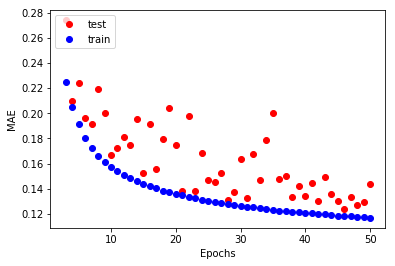

In [13]:
print("NMSE: ")
print(np.mean(nmse))

num_epochs = 50
val_mae_history = [np.mean([x['val_mae'][i] for x in histories]) for i in range(num_epochs)]
mae_history = [np.mean([x['mae'][i] for x in histories]) for i in range(num_epochs)]
plt.plot(range(3, len(val_mae_history) + 1), val_mae_history[2:], 'ro')
plt.plot(range(3, len(mae_history) + 1), mae_history[2:], 'bo')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend(['test', 'train'], loc='upper left')
plt.show()


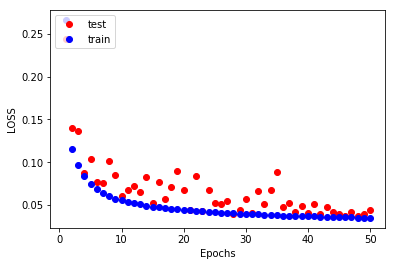

In [14]:
val_loss_history = [np.mean([x['val_loss'][i] for x in histories]) for i in range(num_epochs)]
loss_history = [np.mean([x['loss'][i] for x in histories]) for i in range(num_epochs)]
plt.plot(range(1, len(val_loss_history) + 1), val_loss_history, 'ro')
plt.plot(range(1, len(loss_history) + 1), loss_history, 'bo')
plt.xlabel('Epochs')
plt.ylabel('LOSS')
plt.legend(['test', 'train'], loc='upper left')
plt.show()

In [15]:
model = get_model()

history = model.fit(inputs, targets[['sensor_5']], epochs=50, batch_size=64, verbose=1)
history.history['mae']
model.save("nn_sensor_5.h5")

Epoch 1/50
1125965/1125965 [==============================] - 26s 23us/step - loss: 0.2092 - mae: 0.3064
Epoch 2/50
1125965/1125965 [==============================] - 28s 25us/step - loss: 0.0962 - mae: 0.2180
Epoch 3/50
1125965/1125965 [==============================] - 25s 22us/step - loss: 0.0797 - mae: 0.1908
Epoch 4/50
1125965/1125965 [==============================] - 29s 26us/step - loss: 0.0709 - mae: 0.1742
Epoch 5/50
1125965/1125965 [==============================] - 23s 20us/step - loss: 0.0657 - mae: 0.1650
Epoch 6/50
1125965/1125965 [==============================] - 20s 18us/step - loss: 0.0626 - mae: 0.1595
Epoch 7/50
1125965/1125965 [==============================] - 21s 18us/step - loss: 0.0599 - mae: 0.1549
Epoch 8/50
1125965/1125965 [==============================] - 22s 20us/step - loss: 0.0580 - mae: 0.1513
Epoch 9/50
1125965/1125965 [==============================] - 28s 25us/step - loss: 0.0562 - mae: 0.1478
Epoch 10/50
1125965/1125965 [==========================

In [16]:
model = get_model()

history = model.fit(inputs, targets[['sensor_6']], epochs=50, batch_size=64, verbose=1)
history.history['mae']
model.save("nn_sensor_6.h5")

Epoch 1/50
1125965/1125965 [==============================] - 25s 22us/step - loss: 0.1559 - mae: 0.2848
Epoch 2/50
1125965/1125965 [==============================] - 23s 21us/step - loss: 0.0876 - mae: 0.2057
Epoch 3/50
1125965/1125965 [==============================] - 23s 21us/step - loss: 0.0704 - mae: 0.1767
Epoch 4/50
1125965/1125965 [==============================] - 25s 22us/step - loss: 0.0622 - mae: 0.1617
Epoch 5/50
1125965/1125965 [==============================] - 24s 21us/step - loss: 0.0578 - mae: 0.1532
Epoch 6/50
1125965/1125965 [==============================] - 27s 24us/step - loss: 0.0546 - mae: 0.1471
Epoch 7/50
1125965/1125965 [==============================] - 22s 20us/step - loss: 0.0526 - mae: 0.1430
Epoch 8/50
1125965/1125965 [==============================] - 23s 20us/step - loss: 0.0509 - mae: 0.1397
Epoch 9/50
1125965/1125965 [==============================] - 25s 22us/step - loss: 0.0495 - mae: 0.1367
Epoch 10/50
1125965/1125965 [==========================

In [17]:
model = get_model()

history = model.fit(inputs, targets[['sensor_7']], epochs=50, batch_size=64, verbose=1)
history.history['mae']
model.save("nn_sensor_7.h5")

Epoch 1/50
1125965/1125965 [==============================] - 21s 19us/step - loss: 0.6388 - mae: 0.3469
Epoch 2/50
1125965/1125965 [==============================] - 21s 19us/step - loss: 0.1040 - mae: 0.2190
Epoch 3/50
1125965/1125965 [==============================] - 21s 19us/step - loss: 0.0856 - mae: 0.1894
Epoch 4/50
1125965/1125965 [==============================] - 21s 19us/step - loss: 0.0757 - mae: 0.1729
Epoch 5/50
1125965/1125965 [==============================] - 21s 19us/step - loss: 0.0703 - mae: 0.1635
Epoch 6/50
1125965/1125965 [==============================] - 21s 19us/step - loss: 0.0672 - mae: 0.1579
Epoch 7/50
1125965/1125965 [==============================] - 21s 19us/step - loss: 0.0646 - mae: 0.1533
Epoch 8/50
1125965/1125965 [==============================] - 21s 19us/step - loss: 0.0627 - mae: 0.1498
Epoch 9/50
1125965/1125965 [==============================] - 22s 19us/step - loss: 0.0610 - mae: 0.1467
Epoch 10/50
1125965/1125965 [==========================

In [18]:
model = get_model()
history = model.fit(inputs, targets[['sensor_8']], epochs=50, batch_size=64, verbose=1)
history.history['mae']
model.save("nn_sensor_8.h5")

Epoch 1/50
1125965/1125965 [==============================] - 22s 19us/step - loss: 0.2681 - mae: 0.3237
Epoch 2/50
1125965/1125965 [==============================] - 22s 19us/step - loss: 0.1389 - mae: 0.2445
Epoch 3/50
1125965/1125965 [==============================] - 22s 19us/step - loss: 0.1170 - mae: 0.2121
Epoch 4/50
1125965/1125965 [==============================] - 21s 19us/step - loss: 0.1034 - mae: 0.1906
Epoch 5/50
1125965/1125965 [==============================] - 22s 19us/step - loss: 0.0946 - mae: 0.1761 0s - loss: 0.
Epoch 6/50
1125965/1125965 [==============================] - 22s 19us/step - loss: 0.0894 - mae: 0.1671 0s - loss: 0.0894 - mae: 0.1
Epoch 7/50
1125965/1125965 [==============================] - 22s 19us/step - loss: 0.0861 - mae: 0.1610
Epoch 8/50
1125965/1125965 [==============================] - 22s 19us/step - loss: 0.0832 - mae: 0.1554
Epoch 9/50
1125965/1125965 [==============================] - 22s 19us/step - loss: 0.0810 - mae: 0.1516
Epoch 10/50


In [19]:
model = get_model()

history = model.fit(inputs, targets[['sensor_1']], epochs=50, batch_size=64, verbose=1)
history.history['mae']
model.save("nn_sensor_1.h5")

Epoch 1/50
1125965/1125965 [==============================] - 22s 19us/step - loss: 0.2437 - mae: 0.3090
Epoch 2/50
1125965/1125965 [==============================] - 22s 19us/step - loss: 0.1213 - mae: 0.2119 0s - loss: 0.1214 - mae: 0
Epoch 3/50
1125965/1125965 [==============================] - 22s 19us/step - loss: 0.1024 - mae: 0.1809 0s - loss: 0.102
Epoch 4/50
1125965/1125965 [==============================] - 22s 19us/step - loss: 0.0925 - mae: 0.1643 0s - loss: 0.0924 - mae: 0.164 - ETA: 0s - loss: 0.
Epoch 5/50
1125965/1125965 [==============================] - 22s 19us/step - loss: 0.0868 - mae: 0.1554
Epoch 6/50
1125965/1125965 [==============================] - 22s 19us/step - loss: 0.0835 - mae: 0.1490
Epoch 7/50
1125965/1125965 [==============================] - 22s 20us/step - loss: 0.0804 - mae: 0.1437
Epoch 8/50
1125965/1125965 [==============================] - 22s 19us/step - loss: 0.0785 - mae: 0.1404
Epoch 9/50
1125965/1125965 [==============================] - 22

In [20]:
model = get_model()

history = model.fit(inputs, targets[['sensor_2']], epochs=50, batch_size=64, verbose=1)
history.history['mae']
model.save("nn_sensor_2.h5")

Epoch 1/50
1125965/1125965 [==============================] - 22s 20us/step - loss: 0.2302 - mae: 0.3327
Epoch 2/50
1125965/1125965 [==============================] - 22s 19us/step - loss: 0.1183 - mae: 0.2466
Epoch 3/50
1125965/1125965 [==============================] - 22s 19us/step - loss: 0.0961 - mae: 0.2130
Epoch 4/50
1125965/1125965 [==============================] - 22s 20us/step - loss: 0.0848 - mae: 0.1952
Epoch 5/50
1125965/1125965 [==============================] - 22s 19us/step - loss: 0.0771 - mae: 0.1825
Epoch 6/50
1125965/1125965 [==============================] - 22s 19us/step - loss: 0.0719 - mae: 0.1735
Epoch 7/50
1125965/1125965 [==============================] - 22s 19us/step - loss: 0.0675 - mae: 0.1659
Epoch 8/50
1125965/1125965 [==============================] - 22s 19us/step - loss: 0.0641 - mae: 0.1595
Epoch 9/50
1125965/1125965 [==============================] - 22s 20us/step - loss: 0.0608 - mae: 0.1536
Epoch 10/50
1125965/1125965 [==========================

In [21]:
model = get_model()

history = model.fit(inputs, targets[['sensor_3']], epochs=50, batch_size=64, verbose=1)
history.history['mae']
model.save("nn_sensor_3.h5")

Epoch 1/50
1125965/1125965 [==============================] - 23s 20us/step - loss: 0.1774 - mae: 0.2977
Epoch 2/50
1125965/1125965 [==============================] - 22s 20us/step - loss: 0.0989 - mae: 0.2268
Epoch 3/50
1125965/1125965 [==============================] - 22s 20us/step - loss: 0.0800 - mae: 0.1976
Epoch 4/50
1125965/1125965 [==============================] - 23s 20us/step - loss: 0.0705 - mae: 0.1821
Epoch 5/50
1125965/1125965 [==============================] - 22s 20us/step - loss: 0.0647 - mae: 0.1725
Epoch 6/50
1125965/1125965 [==============================] - 22s 20us/step - loss: 0.0598 - mae: 0.1639
Epoch 7/50
1125965/1125965 [==============================] - 22s 20us/step - loss: 0.0560 - mae: 0.1572
Epoch 8/50
1125965/1125965 [==============================] - 23s 20us/step - loss: 0.0528 - mae: 0.1512
Epoch 9/50
1125965/1125965 [==============================] - 23s 20us/step - loss: 0.0500 - mae: 0.1458
Epoch 10/50
1125965/1125965 [==========================

In [22]:
model = get_model()

history = model.fit(inputs, targets[['sensor_4']], epochs=50, batch_size=64, verbose=1)
history.history['mae']
model.save("nn_sensor_4.h5")

Epoch 1/50
1125965/1125965 [==============================] - 29s 26us/step - loss: 0.1488 - mae: 0.2736
Epoch 2/50
1125965/1125965 [==============================] - 29s 26us/step - loss: 0.0845 - mae: 0.2015
Epoch 3/50
1125965/1125965 [==============================] - 26s 23us/step - loss: 0.0699 - mae: 0.1767 0s - loss: 0.0700 - mae: 
Epoch 4/50
1125965/1125965 [==============================] - 28s 25us/step - loss: 0.0623 - mae: 0.1626
Epoch 5/50
1125965/1125965 [==============================] - 23s 21us/step - loss: 0.0581 - mae: 0.1544
Epoch 6/50
1125965/1125965 [==============================] - 26s 23us/step - loss: 0.0555 - mae: 0.1491
Epoch 7/50
1125965/1125965 [==============================] - 26s 23us/step - loss: 0.0536 - mae: 0.1453
Epoch 8/50
1125965/1125965 [==============================] - 29s 26us/step - loss: 0.0518 - mae: 0.1416
Epoch 9/50
1125965/1125965 [==============================] - 25s 22us/step - loss: 0.0503 - mae: 0.1385
Epoch 10/50
1125965/1125965 [